In [1]:
import numpy as np
import pandas as pd
from scipy import stats as sps
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
from matplotlib.dates import date2num, num2date
from matplotlib import ticker
from matplotlib.colors import ListedColormap

from scipy.interpolate import interp1d

from IPython.display import HTML

%config InlineBackend.figure_format = 'retina'

In [2]:
google = pd.read_csv(
    "https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv",
    parse_dates=['date'], dtype={"sub_region_1": str, "sub_region_2": str},
    index_col=["date"]
)

In [3]:
today = pd.Timestamp.now().strftime("%Y-%m-%d")
google.to_pickle(f"google-mobility-{today}.pkl")

In [4]:
IT = google.loc[google["country_region"] == "Italy"]

In [5]:
Italy = IT.loc[IT.fillna("NONE")["sub_region_1"] == "NONE"]

In [6]:
italy = None
url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv'
italy = pd.read_csv(url,
                     usecols=['data', 'totale_casi'],
                     parse_dates=['data'],
                     index_col=['data'],
                     squeeze=True).sort_index()

# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
GAMMA = 1/7.5

def prepare_cases(cases, cutoff=1, std=2):

    new_cases = cases.diff()
    new_cases[new_cases < 0] = 0

    smoothed = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=std).round()
    
    idx_start = np.searchsorted(smoothed, cutoff)
    
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

def highest_density_interval(pmf, p=.9):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    
    # N x N matrix of total probability mass for each low, high
    total_p = cumsum - cumsum[:, None]
    
    # Return all indices with total_p > p
    lows, highs = (total_p > p).nonzero()
    
    try:
        # Find the smallest range (highest density)
        best = (highs - lows).argmin()
    except Exception as e:
        print("ERR {}".format(e))
        best = 0
    
    low = pmf.index[lows[best]]
    high = pmf.index[highs[best]]
    
    return pd.Series([low, high],
                     index=[f'Low_{p*100:.0f}',
                            f'High_{p*100:.0f}'])

def get_posteriors(sr, sigma=0.15):

    # (1) Calculate Lambda
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 

    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    
    # (4) Calculate the initial prior
    prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 /= prior0.sum()

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0

    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        log_likelihood += np.log(denominator)
    
    return posteriors, log_likelihood

In [7]:
original, smoothed = prepare_cases(italy, std=2)

# Note that we're fixing sigma to a value just for the example
posteriors2, log_likelihood2 = get_posteriors(smoothed, sigma=.20)

# Note that this takes a while to execute - it's not the most efficient algorithm
hdis2 = highest_density_interval(posteriors2, p=.9)

most_likely2 = posteriors2.idxmax().rename('ML')

# Look into why you shift -1
result2 = pd.concat([most_likely2, hdis2], axis=1)

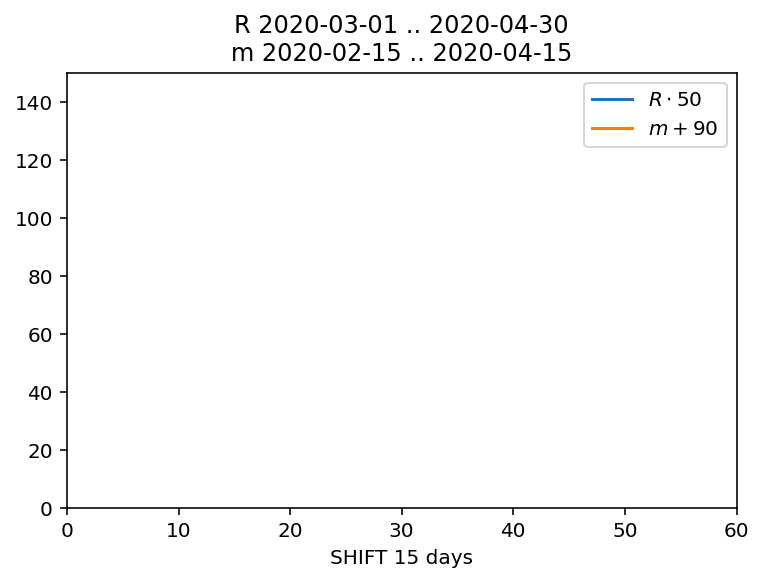

In [64]:
from matplotlib.animation import FuncAnimation

# initialization function: plot the background of each frame
def init_me():
    line1.set_data([], [])
    line2.set_data([], [])
    return ((line1,), (line2,))

def animate_me(i):
    line1.set_data(np.arange(0, x[i].size), x[i])
    line2.set_data(np.arange(0, y[i].size), y[i])
    ax.set_title(t[i])
    ax.set_xlabel(xl[i])
    return ((line1,), (line2,))

m_ = Italy["grocery_and_pharmacy_percent_change_from_baseline"].rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=1).round()
R_ = result2["ML"]
start = pd.Timestamp("2020-03-01 00:00")

x = []
y = []
t = []
xl = []

R_start = R_.loc[R_.index>="2020-03-01"]
R_60 = R_start[:61]

for shift in range(16):

    m_start = start - pd.Timedelta(days=shift)
    m_end = m_start + pd.Timedelta(days=60)
    m = m_.loc[m_.index>=m_start]
    m = m.loc[m.index<=m_end]

    x.append(R_60 * 50)
    y.append(m + 90)
    t.append(
        f"R {R_60.index[0].strftime('%Y-%m-%d')} .. {R_60.index[-1].strftime('%Y-%m-%d')}\n"+
        f"m {m.index[0].strftime('%Y-%m-%d')} .. {m.index[-1].strftime('%Y-%m-%d')}"
    )
    xl.append(f"SHIFT {shift} days")

fig, ax = plt.subplots()
ax.set_xlim(0, 60)
ax.set_ylim(0, 150)
line1, = ax.plot([], [], label="$R \cdot 50$")
line2, = ax.plot([], [], label="$m + 90$")
#line1 = ax.plot(np.arange(0, x[0].size), x[0], label="$R \cdot 50$")[0]
#line2 = ax.plot(np.arange(0, y[0].size), y[0], label="$m + 90$")[0]
ax.legend(loc="best")
anim = FuncAnimation(fig, animate_me, init_func=init_me, interval=2e3, frames=len(x))

HTML(anim.to_html5_video())

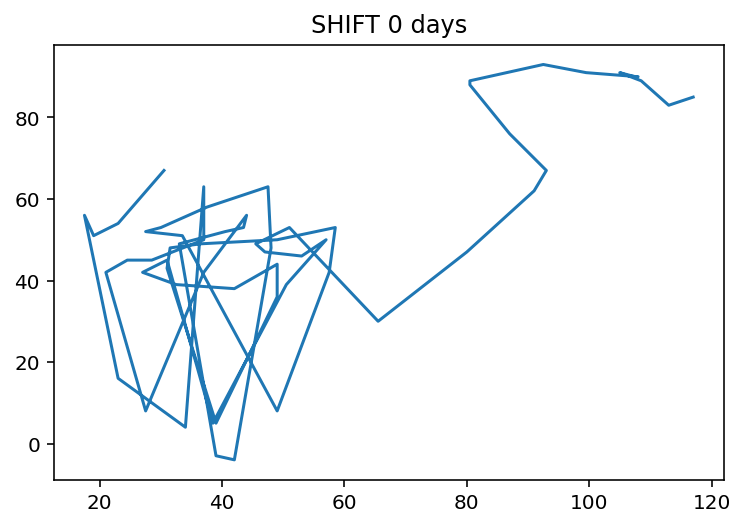

In [35]:
from matplotlib.animation import FuncAnimation
def animate_me(i):
    line1.set_xdata(x[i])
    line1.set_ydata(y[i])
    ax.set_title(t[i])

m_ = Italy ["grocery_and_pharmacy_percent_change_from_baseline"]
R_ = result2["ML"]
start = pd.Timestamp("2020-03-01 00:00")

x = []
y = []
t = []

for shift in range(15):

    m_start = start - pd.Timedelta(days=shift)
    m_end = m_start + pd.Timedelta(days=60)
    m = m_.loc[m_.index>=m_start]
    m = m.loc[m.index<=m_end]
    
    R_start = R_.index[-1] - pd.Timedelta(days=60)
    R = R_.loc[R_.index>=R_start]

    x.append(R * 50)
    y.append(m + 90)
    t.append(f"SHIFT {shift} days")

fig, ax = plt.subplots()
line1 = ax.plot(x[0], y[0])[0]
    
anim = FuncAnimation(fig, animate_me, interval=2e3, frames=len(x))

HTML(anim.to_html5_video())

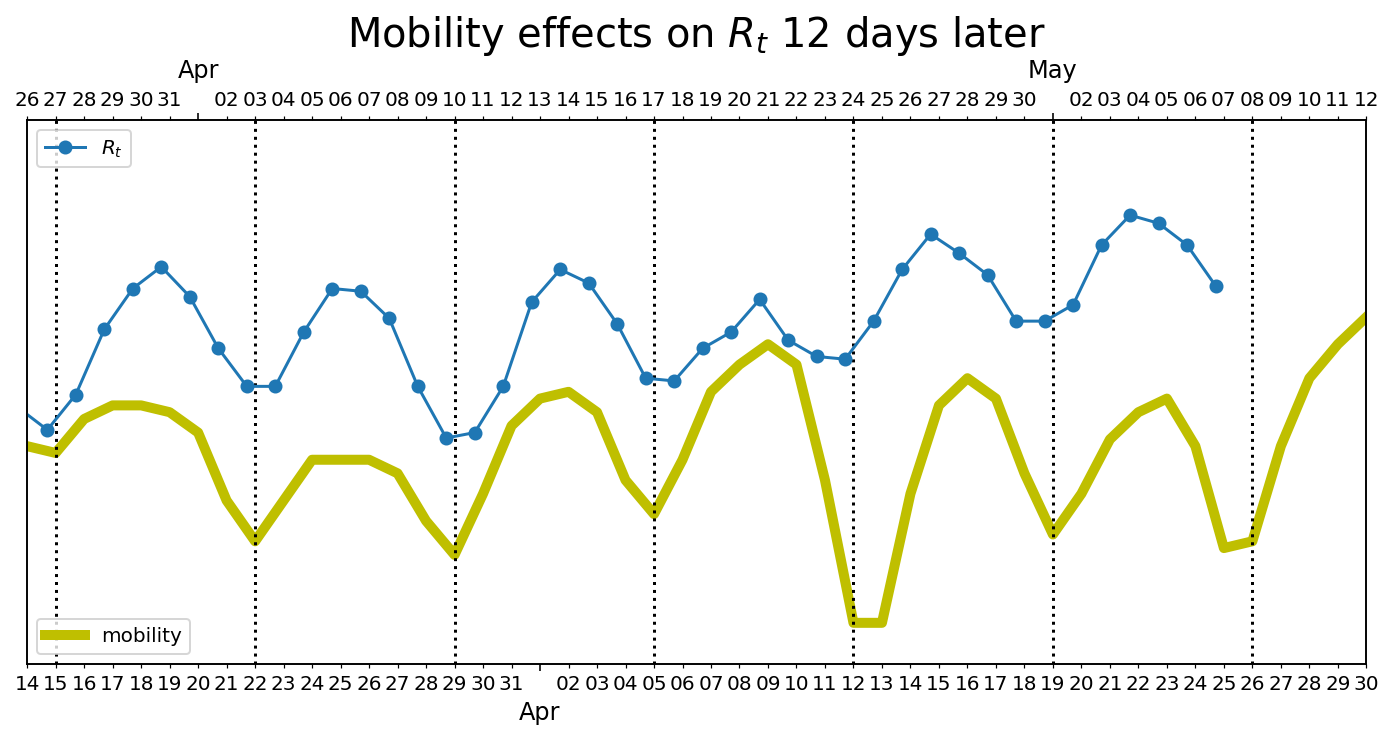

In [71]:
offset = 5 + 7
initial_date = "2020-03-14"
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(
    Italy.loc[initial_date:,].index,
    Italy.loc[initial_date:,]["grocery_and_pharmacy_percent_change_from_baseline"].rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=1).round(),
    label="mobility", c="y", lw=5
)

ax2 = ax.twiny()
ax2.plot(
    result2.index,
    result2["ML"]*-40,
    label="$R_t$", marker="o"
)

start_date = Italy.loc[initial_date:,].index[0]
end_date = Italy.index[-1]
period = (end_date - start_date).days
for days in range(period):
    current_day = start_date + pd.Timedelta(days=days)
    if current_day.strftime("%a") == "Sun":
        ax.axvline(current_day, c="k", ls=":")

ax.set_xlim(start_date, end_date)
ax2.set_xlim(start_date+pd.Timedelta(days=offset), end_date+pd.Timedelta(days=offset))

ax.set_ylim(-80, 0)
ax.set_yticks([])

ax.legend(loc="lower left")
ax2.legend(loc="upper left")

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%d"))
ax.tick_params(axis="x", which='major', labelsize=12, pad=15)

ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax2.xaxis.set_minor_locator(mdates.DayLocator())
ax2.xaxis.set_minor_formatter(mdates.DateFormatter("%d"))
ax2.tick_params(axis="x", which='major', labelsize=12, pad=15)

ax.set_title(f"Mobility effects on $R_t$ {offset} days later", fontsize=20)
plt.show()

$$ P(k | m) = \frac{ P(m|k) \cdot P(k) }{ P(m) } $$

$$ P(m_t|k_t) $$

$$ P(m|\lambda) = \frac{ \lambda^m \cdot e^{-\lambda} }{ m! } $$

In [237]:
# POISSON distribution of m
m = np.arange(0, 50)[:, None]

# Different values of Lambda
lambdas = [10, 15, 20, 25]

# Evaluated the Probability Mass Function (remember: poisson is discrete)
y = sps.poisson.pmf(m, lambdas)

# Show the resulting shape
print(y.shape)

(50, 4)


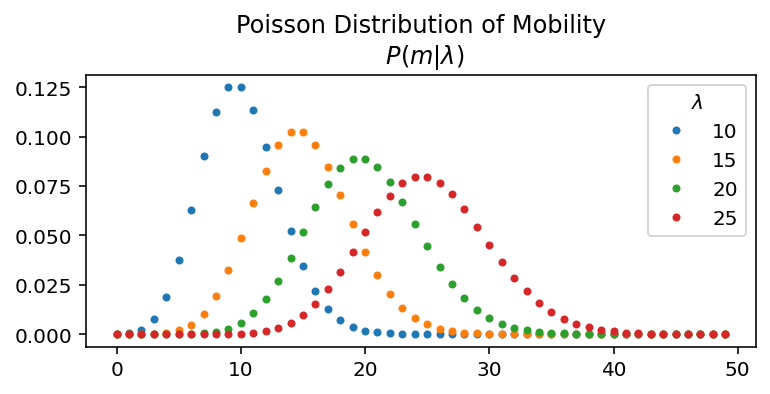

In [238]:
fig, ax = plt.subplots(figsize=(6,2.5))

ax.set(title='Poisson Distribution of Mobility\n $P(m|\lambda)$')

plt.plot(m, y,
         marker='o',
         markersize=3,
         lw=0)
#plt.xlim(-50, 0)
plt.legend(title="$\lambda$", labels=lambdas);

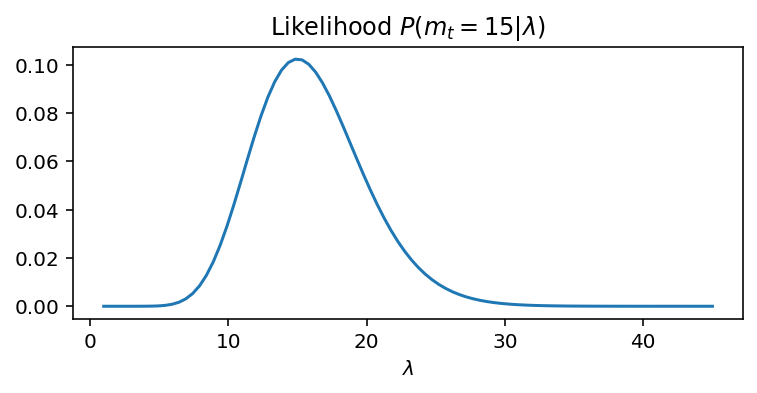

In [239]:
m = 15

lam = np.linspace(1, 45, 90)

likelihood = pd.Series(data=sps.poisson.pmf(m, lam),
                       index=pd.Index(lam, name='$\lambda$'),
                       name='lambda')

likelihood.plot(title=fr'Likelihood $P\left(m_t={m}|\lambda\right)$', figsize=(6,2.5));

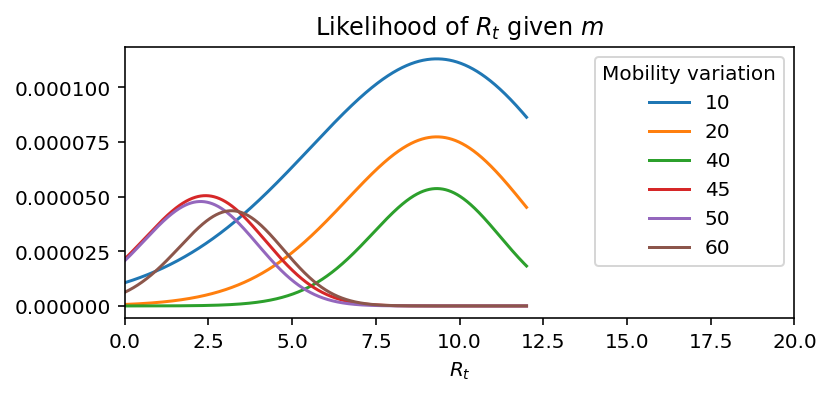

In [241]:
m = np.array([5, 10, 20, 40, 45, 50 , 60])

# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval -> 7 days + 5 before hospital or test
GAMMA = 1/12

# Map Rt into lambda so we can substitute it into the equation below
# Note that we have N-1 lambdas because on the first day of an outbreak
# you do not know what to expect.
lam = m[:-1] * np.exp(GAMMA * (r_t_range[:, None] - 1))

# Evaluate the likelihood on each day and normalize sum of each day to 1.0
likelihood_r_t = sps.poisson.pmf(m[1:], lam)
likelihood_r_t /= np.sum(1-likelihood_r_t, axis=0)

# Plot it
ax = pd.DataFrame(
    data = likelihood_r_t,
    index = r_t_range
).plot(
    title='Likelihood of $R_t$ given $m$',
    xlim=(0,20),
    figsize=(6,2.5)
)

ax.legend(labels=m[1:], title='Mobility variation')
ax.set_xlabel('$R_t$');

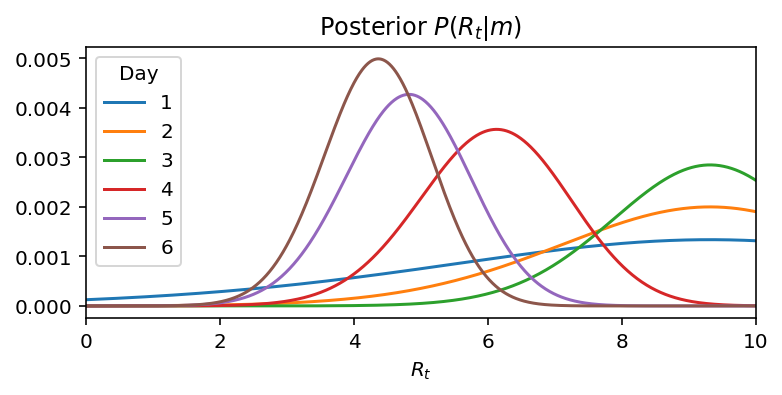

In [242]:
posteriors = likelihood_r_t.cumprod(axis=1)
posteriors = posteriors / np.sum(posteriors, axis=0)

columns = pd.Index(range(1, posteriors.shape[1]+1), name='Day')
posteriors = pd.DataFrame(
    data = posteriors,
    index = r_t_range,
    columns = columns)

ax = posteriors.plot(
    title='Posterior $P(R_t|m)$',
    xlim=(0,10),
    figsize=(6,2.5)
)
ax.legend(title='Day')
ax.set_xlabel('$R_t$');

In [243]:
most_likely_values = posteriors.idxmax(axis=0)
most_likely_values

Day
1    9.32
2    9.32
3    9.32
4    6.13
5    4.82
6    4.36
dtype: float64

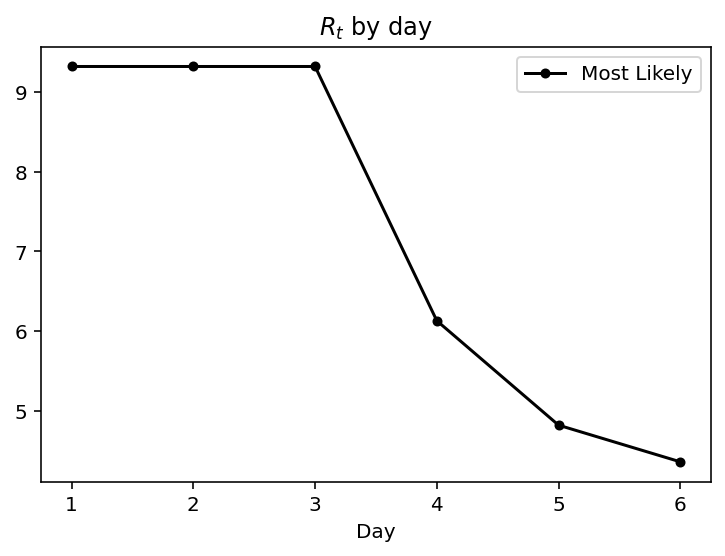

In [244]:
ax = most_likely_values.plot(marker='o',
                             label='Most Likely',
                             title=f'$R_t$ by day',
                             c='k',
                             markersize=4)
ax.legend(loc="best")

In [312]:
mobilities = Italy.loc[initial_date:,]["grocery_and_pharmacy_percent_change_from_baseline"].rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=1.5).round() * -1

In [313]:
OFFSET = 7 + 2

# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval -> 7 days + 5 before hospital or test
GAMMA = 1/OFFSET

def get_m_posteriors(sr, sigma=0.15):

    # (1) Calculate Lambda
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 

    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    
    # (4) Calculate the initial prior
    #prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 = np.ones_like(r_t_range)/len(r_t_range)
    prior0 /= prior0.sum()

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0

    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        log_likelihood += np.log(denominator)
    
    return posteriors, log_likelihood

# Note that we're fixing sigma to a value just for the example
posteriors, log_likelihood = get_m_posteriors(mobilities, sigma=.5)

In [314]:
posteriors

date,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,...,2020-04-21,2020-04-22,2020-04-23,2020-04-24,2020-04-25,2020-04-26,2020-04-27,2020-04-28,2020-04-29,2020-04-30
0.00,0.000833,2.461658e-03,3.049170e-03,3.471155e-03,3.055201e-03,2.264573e-03,1.421581e-03,8.706575e-04,8.477702e-04,1.494315e-03,...,3.514462e-03,4.527814e-03,3.579165e-03,1.537007e-03,9.513002e-04,1.415232e-03,3.922766e-03,6.669137e-03,7.349712e-03,6.793252e-03
0.01,0.000833,2.506325e-03,3.106510e-03,3.535569e-03,3.117390e-03,2.316962e-03,1.459519e-03,8.966383e-04,8.729737e-04,1.532678e-03,...,3.579605e-03,4.603166e-03,3.649996e-03,1.579231e-03,9.797848e-04,1.452544e-03,3.990102e-03,6.747507e-03,7.431409e-03,6.876785e-03
0.02,0.000833,2.550987e-03,3.163936e-03,3.600045e-03,3.179837e-03,2.369822e-03,1.498012e-03,9.231234e-04,8.986714e-04,1.571577e-03,...,3.644849e-03,4.678262e-03,3.721006e-03,1.622095e-03,1.008820e-03,1.490409e-03,4.057378e-03,6.824570e-03,7.511463e-03,6.958993e-03
0.03,0.000833,2.595622e-03,3.221418e-03,3.664546e-03,3.242511e-03,2.423134e-03,1.537056e-03,9.501134e-04,9.248647e-04,1.611007e-03,...,3.710162e-03,4.753055e-03,3.792153e-03,1.665590e-03,1.038407e-03,1.528821e-03,4.124560e-03,6.900269e-03,7.589810e-03,7.039814e-03
0.04,0.000833,2.640203e-03,3.278926e-03,3.729039e-03,3.305382e-03,2.476879e-03,1.576641e-03,9.776086e-04,9.515543e-04,1.650959e-03,...,3.775510e-03,4.827498e-03,3.863400e-03,1.709706e-03,1.068544e-03,1.567774e-03,4.191612e-03,6.974548e-03,7.666388e-03,7.119183e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11.96,0.000833,5.495177e-28,1.681282e-46,1.621991e-55,6.122579e-58,5.026195e-58,8.460874e-58,9.720390e-59,3.878383e-62,7.017999e-67,...,1.385076e-69,8.731680e-69,6.755677e-65,3.999741e-60,6.990289e-61,1.254440e-65,2.529058e-71,1.160194e-71,7.799924e-68,6.926371e-63
11.97,0.000833,4.773241e-28,1.355555e-46,1.262498e-55,4.725312e-58,3.870666e-58,6.491035e-58,7.384240e-59,2.894868e-62,5.146136e-67,...,1.014228e-69,6.455571e-69,5.078091e-65,3.043624e-60,5.263025e-61,9.252676e-66,1.838301e-71,8.519574e-72,5.865058e-68,5.335855e-63
11.98,0.000833,4.144231e-28,1.092598e-46,9.823543e-56,3.645705e-58,2.979793e-58,4.978090e-58,5.607504e-59,2.159919e-62,3.772003e-67,...,7.423792e-70,4.770992e-69,3.815736e-65,2.315252e-60,3.961075e-61,6.821987e-66,1.335667e-71,6.253768e-72,4.408672e-68,4.109324e-63
11.99,0.000833,3.596438e-28,8.803799e-47,7.641180e-56,2.811819e-58,2.293194e-58,3.816467e-58,4.256719e-59,1.610929e-62,2.763666e-67,...,5.431800e-70,3.524680e-69,2.866172e-65,1.760570e-60,2.980080e-61,5.027827e-66,9.700715e-72,4.588830e-72,3.312811e-68,3.163768e-63


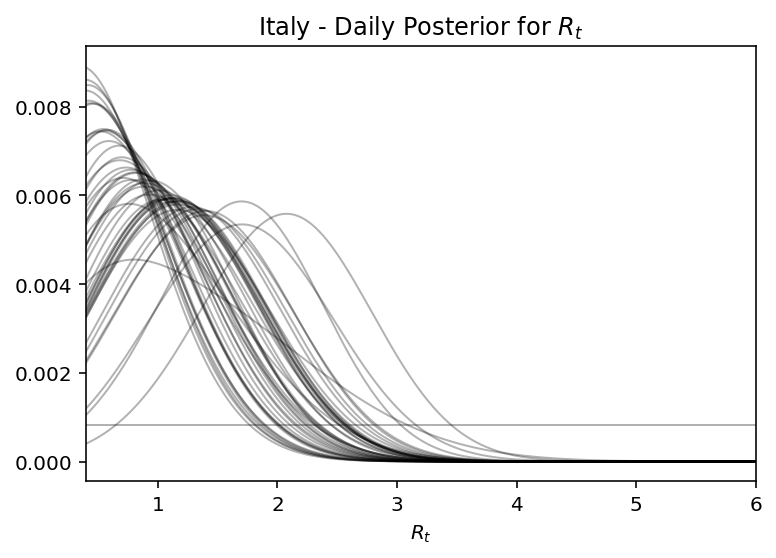

In [315]:
ax = posteriors.plot(title='Italy - Daily Posterior for $R_t$',
           legend=False, 
           lw=1,
           c='k',
           alpha=.3,
           xlim=(0.4,6))

ax.set_xlabel('$R_t$');

In [316]:
# Note that this takes a while to execute - it's not the most efficient algorithm
hdis = highest_density_interval(posteriors, p=.9)

most_likely = posteriors.idxmax().rename('ML')

# Look into why you shift -1
result = pd.concat([most_likely, hdis], axis=1)

result.tail()

,ML,Low_90,High_90
date,,,
2020-04-26,1.18,0.13,2.21
2020-04-27,0.68,0.00,1.69
2020-04-28,0.39,0.00,1.41
2020-04-29,0.35,0.00,1.33
2020-04-30,0.39,0.00,1.37


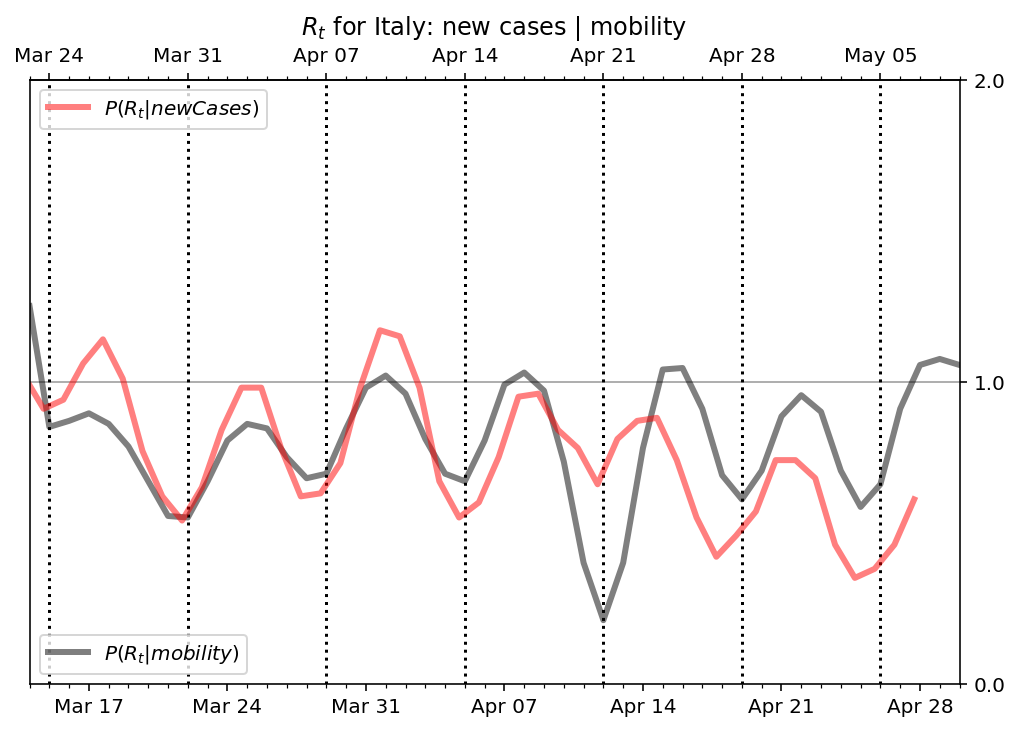

In [337]:
def plot_rt(result=None, result2=None, ax=None, state_name="Italy"):
    
    fig, ax = plt.subplots(figsize=(600/72,400/72))
    
    ax.set_title(f"{state_name}")
    
    start_date = result.loc[initial_date:,].index[0]
    end_date = result.index[-1]
    period = (end_date - start_date).days
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(ABOVE,MIDDLE,25),
        np.linspace(MIDDLE,BELOW,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, (2.5-values)/2, c='k', lw=3, zorder=1, alpha=.5, label="$P(R_t|mobility)$")
    #ax.scatter(index,
    #           (2.5-values)/2,
    #           s=40,
    #           lw=.5,
    #           c=cmap(color_mapped(values)),
    #           edgecolors='k', zorder=2)
    
    
    index2 = result2['ML'].index.get_level_values('data')
    values2 = result2['ML'].values
    
    # Plot dots and line
    ax2 = ax.twiny()
    ax2.plot(index2, values2, c='r', lw=3, zorder=1, alpha=.5, label="$P(R_t|newCases)$")
    ax2.set_xlim(start_date+pd.Timedelta(days=OFFSET), end_date+pd.Timedelta(days=OFFSET))

#    ax.scatter(index2,
#               values2,
#               s=40,
#               lw=.5,
#               c=cmap(color_mapped(values)),
#               edgecolors='k', zorder=2)
    
    
    # Aesthetically, extrapolate credible interval by 1 day either side
#    lowfn = interp1d(date2num(index),
#                     result['Low_90'].values,
#                     bounds_error=False,
#                     fill_value='extrapolate')
#    
#    highfn = interp1d(date2num(index),
#                      result['High_90'].values,
#                      bounds_error=False,
#                      fill_value='extrapolate')
#    
#    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
#                             end=index[-1]+pd.Timedelta(days=1))
#    
#    ax.fill_between(extended,
#                    lowfn(date2num(extended)),
#                    highfn(date2num(extended)),
#                    color='k',
#                    alpha=.1,
#                    lw=0,
#                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax2.xaxis.set_major_locator(mdates.WeekdayLocator())
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax2.xaxis.set_minor_locator(mdates.DayLocator())
    
    for days in range(period):
        current_day = start_date + pd.Timedelta(days=days)
        if current_day.strftime("%a") == "Sun":
            ax.axvline(current_day, c="k", ls=":")
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 2.0)
    ax.set_xlim(start_date, end_date)
    ax.legend(loc="lower left")
    ax2.legend(loc="upper left")
    fig.set_facecolor('w')
    ax.set_title(f'$R_t$ for Italy: new cases | mobility')
    plt.show()

plot_rt(result=result, result2=result2, ax=ax)